In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed May 11 14:35:34 2022

@author: User
"""



###############################################################################
### 라이브러리 불러오기
###############################################################################

import os
import time
import copy

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
#%matplotlib inline

import torch
import cv2

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split


from torchvision.datasets import ImageFolder
from torchvision.datasets import DatasetFolder
import torchvision.transforms as transforms
import torchvision

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler


from torchsummary import summary

from time import perf_counter, sleep
import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

In [3]:
train_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/train.csv')
test_df = pd.read_csv('C:/Users/sanda/Desktop/dacon/test.csv')

In [4]:
# import shutil

# send_folder = 'C:/Users/sanda/Desktop/dacon/train_imgs_wsi/'
# receive_foler = 'C:/Users/sanda/Desktop/dacon/train_imgs_wsi_class/c1'

In [5]:
# cnt = 0

# for i , row in train_df.iterrows():
#     if row['N_category'] == 1:
#         cnt +=1
#         file_name = row['img_path'].split('/')[-1].split('.')[0]
#         shutil.copy(send_folder+file_name+'.npy' , receive_foler)
        
# print(cnt)

In [6]:
CFG = {
    'IMG_SIZE':224, # fixed
    'EPOCHS':50,
    'LEARNING_RATE':1e-4,
    'BATCH_SIZE':16,
    'SEED':41
}

In [7]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

In [8]:
###############################################################################
## data
###############################################################################
#import splitfolders



#Hand_craft_bounding
input_folder_path = 'C:/Users/sanda/Desktop/dacon/train_imgs_wsi_class/original'
output_folder_path = 'C:/Users/sanda/Desktop/dacon/train_imgs_wsi_class/train_test'

# import splitfolders

# if not os.path.isdir(output_folder_path):
    
#     os.makedirs(output_folder_path)
    
# splitfolders.ratio(input_folder_path,output = output_folder_path,ratio=(0.8,0.2))

In [9]:
# ###############################################################################
# ### 데이터 불러오기 with 간단한 전처리 
# ###############################################################################

# image_resize = (224,224)

# T = transforms.Compose([
                        
#                         transforms.Grayscale(num_output_channels=1),
#                         transforms.RandomRotation(degrees=20),
#                         transforms.RandomHorizontalFlip(p=0.5),
#                         transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0),
#                         transforms.Resize(image_resize), # (h, w) 순서
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.5), (0.5))
                   
#                        ])

# valid_T = transforms.Compose([
                        
#                         transforms.Grayscale(num_output_channels=1),
#                         transforms.Resize(image_resize), # (h, w) 순서
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.5), (0.5))

#                        ])

# train_dataset = ImageFolder(root=os.path.join(output_folder_path,'train'), transform=T)
# val_dataset = ImageFolder(root=os.path.join(output_folder_path,'val'),transform =valid_T)

In [10]:
def npy_loader(path):
    #sample = torch.from_numpy(np.load(path))
    sample = np.load(path)
    return sample

In [11]:
###############################################################################
### 데이터 불러오기 with 간단한 전처리 
###############################################################################

# fixed

T = transforms.Compose([
#                         transforms.Grayscale(num_output_channels=1),
#                         transforms.RandomRotation(degrees=20),
#                         transforms.RandomHorizontalFlip(p=0.5),
#                         transforms.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0),
#                         transforms.Resize(image_resize), # (h, w) 순서
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5), (0.5))
                   
                       ])

valid_T = transforms.Compose([
#                         transforms.Grayscale(num_output_channels=1),
#                         transforms.Resize(image_resize), # (h, w) 순서
                        transforms.ToTensor(),
                        #transforms.Normalize((0.5), (0.5))

                       ])

train_dataset = DatasetFolder(root=os.path.join(output_folder_path,'train'), loader=npy_loader,extensions=['.npy'],transform=T)
val_dataset = DatasetFolder(root=os.path.join(output_folder_path,'val'),loader=npy_loader,extensions=['.npy'],transform =valid_T)

In [12]:
###############################################################################
### DataLoader, batch_size, shuffle, .... 
###############################################################################
batch_size = 16
# #batch_size = 4
# #num_workers = 4 * torch.cuda.device_count()
num_workers = 0 #수정

train_loaders = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers , pin_memory=True)
val_loaders = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)


dataloaders = dict()
dataloaders['train'] = train_loaders
dataloaders['val'] = val_loaders

In [13]:
# ###############################################################################
# ###데이터가 잘 load 되었는지 확인하기
# ###############################################################################

# images, labels =  iter(train_loaders).next()

# MEAN = torch.tensor([0.5])
# STD = torch.tensor([0.5])
# for data, i in train_loaders:
#     print(data.shape) # (batch_size, c, h, w)
    
#     data = data*STD+MEAN
#     tmp_data = data.numpy().transpose(0, 2, 3, 1) 
#     img = tmp_data[3]
#     plt.imshow(img)
#     plt.show()
    
#     break

In [14]:
###############################################################################
### (Pre-Trained) Model resnet 로드 및 확인
###############################################################################
#model = torchvision.models.resnet34(pretrained=True)

#model = torchvision.models.resnet50(pretrained=True)
#model = torchvision.models.resnet152(pretrained=True)
model = torchvision.models.resnet50(pretrained=True)

layer_set = []
layer_names = []

for name, layer in model.named_modules():
    layer_set.append(layer)
    layer_names.append(name)

layer_names[1]
layer_names[-1]

#model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)#
#model.fc = nn.Linear(in_features=512, out_features=3, bias=True)

model.conv1 = nn.Conv2d(312, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
model.avgpool = nn.AdaptiveMaxPool2d(output_size=(1, 1))
model.fc = nn.Linear(in_features=2048, out_features=2)

In [15]:
model

ResNet(
  (conv1): Conv2d(312, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1

In [16]:
# class ImgFeatureExtractor(nn.Module):
#     def __init__(self):
#         super(ImgFeatureExtractor, self).__init__()
#         #self.backbone = models.efficientnet_b0(pretrained=True) # fixed
#         self.backbone = torchvision.models.convnext_tiny(pretrained=False)
#         #self.backbone = models.convnext_base(pretrained=False)
#         self.first_conv = nn.Conv2d(96,3,kernel_size=(3,3)) #fixed
#         #self.embedding = nn.Linear(1000,512) # fixed
#         #self.embedding = nn.Linear(1000,128)
#         self.classifier = nn.Sequential(
#             nn.Linear(in_features=1000, out_features=1), # fixed
#             #nn.Linear(in_features=1024, out_features=1),
#             #nn.Sigmoid(),
#         )
#     def forward(self, x):
#         x = self.first_conv(x) #fixed
#         x = self.backbone(x)
#         #x = self.embedding(x) #fixed
#         x = self.classifier(x)
#         return x

In [17]:
# model = ImgFeatureExtractor()

In [18]:
###############################################################################
### GPU 세팅
###############################################################################


#GPU 세팅
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
model = model.to(device)

In [19]:
from torchsummary import summary
summary(model.to(device) , input_size=(312,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]         978,432
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
print(device)

cuda


In [21]:
###############################################################################
### Trainin  Setting
###############################################################################


optimizer = optim.Adam(model.parameters(), lr=0.0001)# 손실함수 정의 및 업데이트 방법결정
criterion = nn.CrossEntropyLoss().to(device)
#criterion = nn.BCEWithLogitsLoss().to(device)
#epoch에 따라 학습률 조절: 기본적으로 epoch이 증가함에 따라 학습률 감소 시킴
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)#7단계 마다 0.1비율만큼 학습률 감소

In [22]:
gc.collect()

18

In [23]:
# def force_cudnn_initialization():
#     s = 32
#     dev = torch.device('cuda')
#     torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
    
# force_cudnn_initialization()

In [24]:
###############################################################################
### Trainining Process
###############################################################################


best_model_weights = copy.deepcopy(model.state_dict())




best_acc = 0.0
epoch_loss_history = []
epoch_acc_history = []
val_acc_history = []
val_loss_history = []



start = perf_counter()

epochs = 50


for epoch in range(epochs):
    print('Epoch {}/{}'.format(epoch, epochs - 1))
    print('-' * 10)
    
    start_gpu = perf_counter()
    
    for phase in ['train','val']:
    
        if phase == 'train':

            model.train()
        else:
            model.eval()
            
        running_loss = 0.0
        running_corrects = 0
        num_cnt  = 0
    
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)
            #print(inputs.shape)

            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase=='train'):
                
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                #print(outputs)
                #print(preds)
                #print(labels)
                loss = criterion(outputs, labels)
                #loss = criterion(preds.float(), labels.float())
                
                if phase=='train':
                
                    loss.requires_grad_(True)
                    #print('backward 진행')
                    loss.backward()

                    optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) 
            running_corrects += torch.sum(preds == labels.data)
            num_cnt += len(labels)
                
        if phase == 'train':
            
            scheduler.step()

        epoch_loss = float(running_loss/num_cnt)
        epoch_acc = float((running_corrects.double()/num_cnt).cpu()*100)
    
        if phase == 'train':
    
            epoch_loss_history.append(epoch_loss)
            epoch_acc_history.append(epoch_acc)
    
        else:
    
            val_acc_history.append(epoch_acc)
            val_loss_history.append(epoch_loss)
            
        
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    

        if phase=='val' and epoch_acc > best_acc:
            
            best_idx = epoch
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            print('==> best model saved - %d / %.1f'%(best_idx, best_acc))
        
          
    end_gpu = perf_counter()
    print(f"1epoch-gpu Time taken to execute code : {end_gpu-start_gpu}")    


end = perf_counter()
print(f"Time taken to execute code : {end-start}")      
print('Best valid Acc: %d - %.1f' %(best_idx, best_acc))     


#plt.plot(val_loss_history)
#plt.plot(val_acc_history)

gc.collect()
torch.cuda.empty_cache()

Epoch 0/49
----------
train Loss: 0.7952 Acc: 57.0713
val Loss: 2.2757 Acc: 51.2438
==> best model saved - 0 / 51.2
1epoch-gpu Time taken to execute code : 56.171983600000004
Epoch 1/49
----------
train Loss: 0.6438 Acc: 66.2078
val Loss: 0.6566 Acc: 58.2090
==> best model saved - 1 / 58.2
1epoch-gpu Time taken to execute code : 50.7870667
Epoch 2/49
----------
train Loss: 0.6458 Acc: 70.0876
val Loss: 0.7371 Acc: 49.2537
1epoch-gpu Time taken to execute code : 50.4089386
Epoch 3/49
----------
train Loss: 0.5111 Acc: 75.3442
val Loss: 1.1964 Acc: 55.2239
1epoch-gpu Time taken to execute code : 50.533872
Epoch 4/49
----------
train Loss: 0.3982 Acc: 82.3529
val Loss: 2.1966 Acc: 51.2438
1epoch-gpu Time taken to execute code : 51.33427310000002
Epoch 5/49
----------
train Loss: 0.3102 Acc: 85.9825
val Loss: 1.0479 Acc: 63.6816
==> best model saved - 5 / 63.7
1epoch-gpu Time taken to execute code : 50.63800649999996
Epoch 6/49
----------
train Loss: 0.2424 Acc: 90.6133
val Loss: 1.9590 Ac

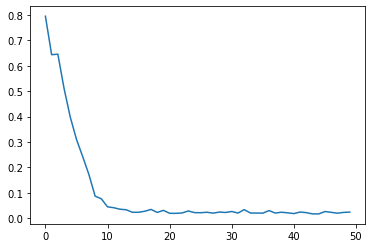

In [25]:
plt.plot(epoch_loss_history)

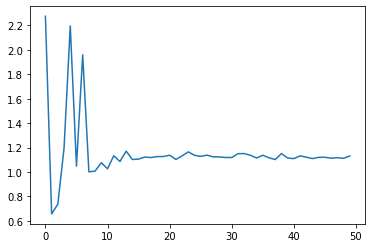

In [26]:
plt.plot(val_loss_history)

In [27]:
# ###############################################################################
# ### best model 저장
# ###############################################################################

# update_model_path = '/content/drive/MyDrive'
# torch.save(best_model_wts,os.path.join(update_model_path,'hair_loss_detection_best_model_size_224_by_224_ver2.pt'))

In [28]:
import torch
import torch.nn.functional as F

x = torch.randn((256, 96, 128, 128)).cuda()

a = F.avg_pool2d(x, x.size()[2:])
b = F.adaptive_avg_pool2d(x, (1, 1))
d = F.adaptive_max_pool2d(x, (1, 1))
c = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)

In [29]:
x.shape

torch.Size([256, 96, 128, 128])

In [30]:
x.size()[2:]

torch.Size([128, 128])

In [31]:
a.shape

torch.Size([256, 96, 1, 1])

In [32]:
b.shape

torch.Size([256, 96, 1, 1])

In [33]:
d.shape

torch.Size([256, 96, 1, 1])